In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')
import seaborn as sns

#### load dataset

In [3]:
df_TOCC = pd.read_csv('../../datasets/TypeOfContractChannel.csv')
df_TOCC[:3]

,id,type_of_contract,type_of_contract2,channel,datetime,Term,payment_type,product,amount,state,overdue_count,overdue,credit rating,bank,cancellation,age,Mileage
0,66758234,렌탈,Normal,서비스 방문,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,9.0,새마을금고,정상,43.0,1862.0
1,66755948,렌탈,Extension_Rental,서비스 방문,2019-10-20,60,카드이체,K1,102900,계약확정,0,없음,2.0,현대카드,정상,62.0,2532.0
2,66756657,렌탈,Normal,홈쇼핑/방송,2019-10-20,60,CMS,K1,96900,계약확정,0,없음,8.0,우리은행,정상,60.0,2363.0


### 분석 대상
 ⇒ 궁금한 점: 한 건의 거래 내역당 영향 준 변수는 무엇일까?
- 목표 변수: amount 
- 설명 변수: 'type_of_contract','datetime', 'product', 'age'

In [4]:
df_TOCC.columns

Index(['id', 'type_of_contract', 'type_of_contract2', 'channel', 'datetime',
       'Term', 'payment_type', 'product', 'amount', 'state', 'overdue_count',
       'overdue', 'credit rating', 'bank', 'cancellation', 'age', 'Mileage'],
      dtype='object')

### 1. EDA 전략

#### 해당 변수(목표 변수와 설명 변수) 선택
    - 이상치와 결측치 처리
    

In [5]:
df_TOCC[['type_of_contract','datetime', 'product', 'amount', 'age']].iloc[:2]

,type_of_contract,datetime,product,amount,age
0,렌탈,2019-10-20,K1,96900,43.0
1,렌탈,2019-10-20,K1,102900,62.0


In [6]:
df_TOCC_choose = df_TOCC[['type_of_contract','datetime', 'product', 'amount', 'age']]
df_TOCC_choose[:2]

,type_of_contract,datetime,product,amount,age
0,렌탈,2019-10-20,K1,96900,43.0
1,렌탈,2019-10-20,K1,102900,62.0


In [7]:
# df_TOCC_choose.info()
## isnull().sum()을 통해 null 값이 얼마나 빠져있는지 확인할것. 
df_TOCC_choose.isnull().sum()

type_of_contract        4
datetime                0
product                 1
amount                  0
age                 10795
dtype: int64

In [8]:
## 일단 null 값은 drop 시키는걸로 결정
# df_TOCC_choose = df_TOCC_choose.dropna()
df_TOCC_choose.isnull().sum()

type_of_contract        4
datetime                0
product                 1
amount                  0
age                 10795
dtype: int64

####범주형과 연속형(순서형)으로 dtype 변형

In [9]:
# datetime을 datetime으로 바꾸기
df_TOCC_choose['datetime'] = pd.to_datetime(df_TOCC_choose['datetime'])

C:\Users\01-15\AppData\Local\Temp\ipykernel_12892\3572669479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TOCC_choose['datetime'] = pd.to_datetime(df_TOCC_choose['datetime'])


In [10]:
df_TOCC_choose.dtypes

type_of_contract            object
datetime            datetime64[ns]
product                     object
amount                       int64
age                        float64
dtype: object

In [11]:
df_TOCC_choose.describe()

,amount,age
count,51304.000000,40509.000000
mean,93994.980021,46.608285
std,15305.147334,13.465977
min,54603.000000,20.000000
25%,81900.000000,37.000000
50%,96900.000000,46.000000
75%,98400.000000,56.000000
max,215700.000000,107.000000


In [12]:
df_TOCC_choose.describe(include='all')

C:\Users\01-15\AppData\Local\Temp\ipykernel_12892\2768377583.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_TOCC_choose.describe(include='all')


,type_of_contract,datetime,product,amount,age
count,51300,51304,51303,51304.000000,40509.000000
unique,2,101,6,NaN,NaN
top,렌탈,2019-10-29 00:00:00,K1,NaN,NaN
freq,46481,817,39134,NaN,NaN
first,NaN,2019-10-20 00:00:00,NaN,NaN,NaN
last,NaN,2020-02-03 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,93994.980021,46.608285
std,NaN,NaN,NaN,15305.147334,13.465977
min,NaN,NaN,NaN,54603.000000,20.000000
25%,NaN,NaN,NaN,81900.000000,37.000000


#### 변수간의 상관성 확인
    - 목표 변수: 정규화 여부 판단
    - 목표 변수와 각 설명 변수 간에 관계 확인

<Axes: xlabel='amount', ylabel='Count'>

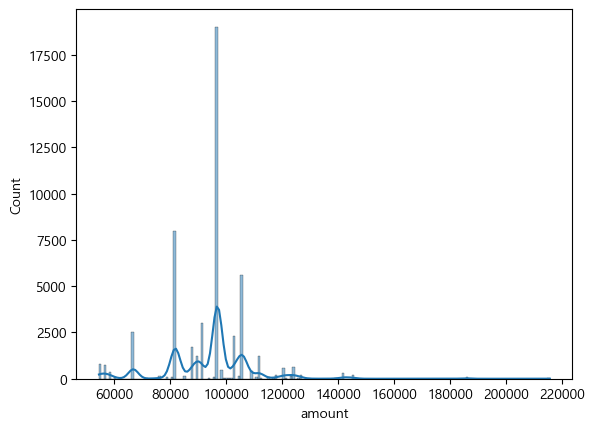

In [13]:
# 먼저 단일변수로 목표변수 확인해보기
sns.histplot(data=df_TOCC_choose, x='amount', kde=True)
## 일단 모양은 비정규분포처럼 보임_여기선 판별이 불가능 > 추후 검증 필요

## 연속형/연속형 일때
⇒ 상관관계 corr() correlation 먼저 확인하기

In [14]:
df_TOCC_choose.corr() ## 관계성이 있을 경우 pairplot()

C:\Users\01-15\AppData\Local\Temp\ipykernel_12892\1313679787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_TOCC_choose.corr() ## 관계성이 있을 경우 pairplot()


,amount,age
amount,1.000000,-0.003537
age,-0.003537,1.000000


### 범주형 /연속형
⇒ 최상 or 최하 해당하는 개수 선택
  = 항목 중에 영향을 주는 것을 선택
  ** 이때 각 변수 안에는 항목 2개 이상이 필요함. 

<Axes: xlabel='type_of_contract', ylabel='amount'>

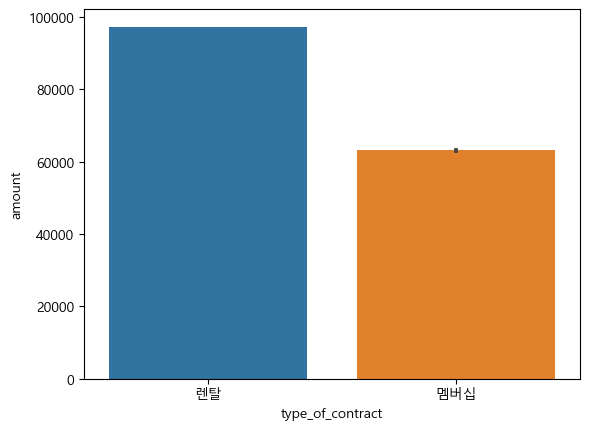

In [15]:
## 범주_type_of_contract, 연속형 : 범주형에 2개 존재. 
sns.barplot(data=df_TOCC_choose, x='type_of_contract', y='amount')

<Axes: xlabel='product', ylabel='amount'>

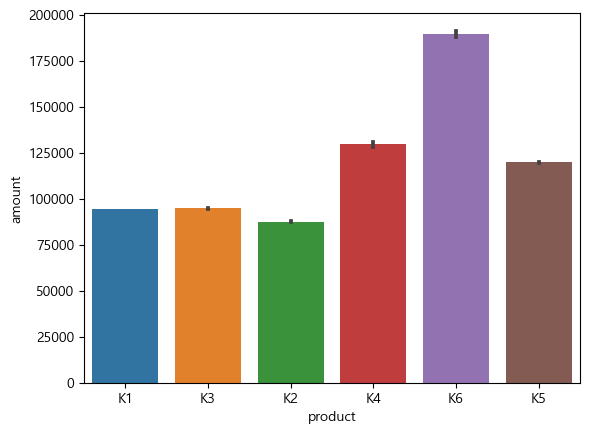

In [16]:
## 범주_product, 연속형 : 범주형에 6개 존재. 이 중에 기준을 정해서 변수의 항목을 선택하면 됨. 
#### 여기서 상위 2개만 추출. 이때는 condition을 이용해서 걸러낼수있다. 
sns.barplot(data=df_TOCC_choose, x='product', y='amount')

In [17]:
## 변수 안에 있는 원하는 항목 필터링_ 이때 이건 product의 평균의 TOP3를 걸러내는것임. 
conditions = (df_TOCC_choose['product'] == 'K4') | (df_TOCC_choose['product'] == 'K5') | (df_TOCC_choose['product'] == 'K6')
df_TOCC_choose_product = df_TOCC_choose.loc[conditions]
df_TOCC_choose_product[:3]

,type_of_contract,datetime,product,amount,age
58,렌탈,2019-10-21,K4,126900,28.0
110,렌탈,2019-10-21,K4,125700,23.0
156,렌탈,2019-10-21,K4,125700,41.0


<Axes: xlabel='product', ylabel='amount'>

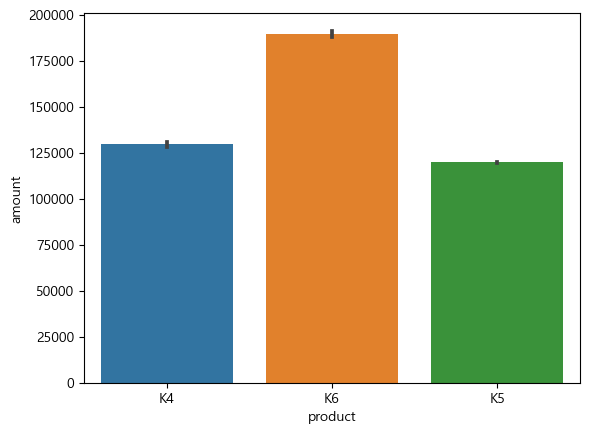

In [18]:
sns.barplot(data=df_TOCC_choose_product, x='product', y='amount')

<Axes: xlabel='datetime', ylabel='amount'>

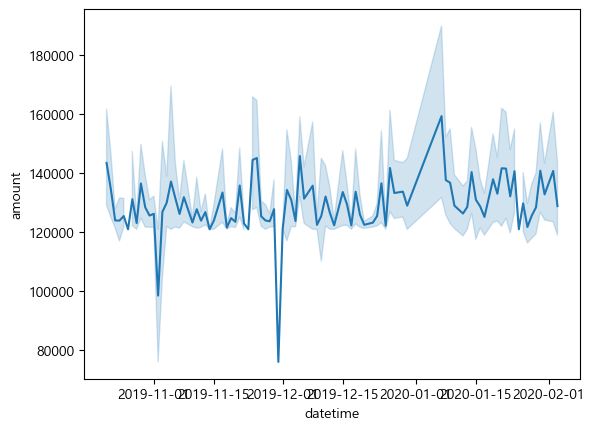

In [19]:
## 순서형 /연속형
sns.lineplot(data=df_TOCC_choose_product, x='datetime', y='amount')

In [20]:
## 요일별로
#### .loc[]: column이 없는 경우, 있는 경우 []
df_TOCC_choose_product['day_name']= df_TOCC_choose_product['datetime'].dt.day_name()
df_TOCC_choose_product['day_name'].value_counts()

C:\Users\01-15\AppData\Local\Temp\ipykernel_12892\3244256561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TOCC_choose_product['day_name']= df_TOCC_choose_product['datetime'].dt.day_name()


Thursday     205
Friday       188
Tuesday      184
Monday       173
Wednesday    173
Sunday       163
Saturday       6
Name: day_name, dtype: int64

<Axes: xlabel='day_name', ylabel='amount'>

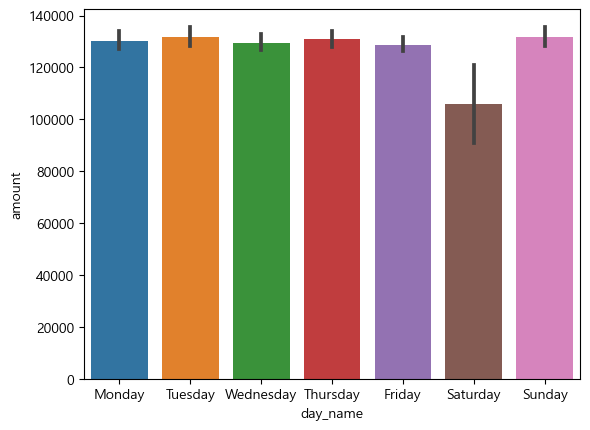

In [21]:
## 위의 요일별로 나눠버리면 범주형 / 연속형
sns.barplot(data=df_TOCC_choose_product, x='day_name', y='amount')

#### 보고서
    → 변수간 상관성 확인검증 여부
        1. 목표 변수 : 비정규 분포 형태를 띔
        2. 설명 변수 
            - type_of_contract: 범주형, 2개 항목
            - product: 범주형, 6개 항목_평균 top 3개 항목
            - age: 연속형, 상관계수: -0.003539 < 0.5보다? 작아서 설명 변수 채택 어려움. 
            - datetime: 순서형, 분포 특성상 요일별로 변환. 
            - day_name: 요일별 분석 위한 컬럼 추가